In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!mkdir -p hateful_memes
!unzip -q gdrive/MyDrive/data.zip -d /content/hateful_memes/

!pip install --quiet \
    transformers torch torchvision tqdm scikit-learn matplotlib seaborn wandb \
    pillow opencv-python ftfy regex git+https://github.com/openai/CLIP.git


In [ ]:
import os, json, random, re
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score
)
from tqdm.notebook import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MODEL_TYPE = "BLIP"
if MODEL_TYPE == "CLIP":
    import clip
    backbone, _ = clip.load("ViT-B/32", device=device)
    def extract_image_feats(imgs):
        return backbone.encode_image(imgs).float()
    def extract_text_feats(tokens):
        return backbone.encode_text(tokens).float()
    tokenize_fn = lambda texts: clip.tokenize(texts)

elif MODEL_TYPE == "BLIP":
    from transformers import BlipProcessor, BlipModel
    processor = BlipProcessor.from_pretrained(
        "Salesforce/blip-image-captioning-base",
        use_fast=True
    )
    backbone = BlipModel.from_pretrained(
        "Salesforce/blip-image-captioning-base"
    ).to(device)

    def extract_image_feats(imgs):
        pix = processor(
            images=[t.cpu().permute(1,2,0).numpy() for t in imgs],
            return_tensors="pt"
        ).pixel_values.to(device)
        return backbone.get_image_features(pixel_values=pix).float()

    def extract_text_feats(texts):
        enc = processor(
            text=texts, return_tensors="pt", padding=True
        ).to(device)
        return backbone.get_text_features(**enc).float()

    tokenize_fn = None

elif MODEL_TYPE == "SIGLIP":
    from siglip import SigLIPProcessor, SigLIPModel
    processor = SigLIPProcessor.from_pretrained("siglip-base")
    backbone  = SigLIPModel.from_pretrained("siglip-base").to(device)
    def extract_image_feats(imgs):
        enc = processor(
            images=[t.cpu().permute(1,2,0).numpy() for t in imgs],
            return_tensors="pt"
        ).to(device)
        return backbone.get_image_features(**enc).float()
    def extract_text_feats(texts):
        enc = processor(
            text=texts, return_tensors="pt", padding=True
        ).to(device)
        return backbone.get_text_features(**enc).float()
    tokenize_fn = None

else:
    raise ValueError(f"Unknown MODEL_TYPE {MODEL_TYPE}")


Using device: cuda


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

In [ ]:
LEXICON = {
    'racial':   {'slur1':3, 'slur2':3},
    'gender':   {'insult1':1, 'insult2':1},
    'religion': {'slurA':2, 'slurB':2},
    'political':{'termX':1},
    'other':    {'hate':1}
}
SEVERITY_THRESHOLDS = (2, 5)  # medium>=2, high>=5

def heuristic_labels(text: str):
    scores = {k:0 for k in LEXICON}
    t = text.lower()
    for subtype, words in LEXICON.items():
        for w, pts in words.items():
            scores[subtype] += t.count(w)*pts
    total = sum(scores.values())
    if total >= SEVERITY_THRESHOLDS[1]:
        sev='high'
    elif total >= SEVERITY_THRESHOLDS[0]:
        sev='medium'
    else:
        sev='low'
    subtypes = [s for s,v in scores.items() if v>0]
    return sev, subtypes

from clip.simple_tokenizer import SimpleTokenizer
def safe_tokenize(texts, context_length=77):
    if isinstance(texts,str): texts=[texts]
    try:
        return clip.tokenize(texts, context_length=context_length)
    except RuntimeError:
        tokenizer = SimpleTokenizer()
        sot, eot = tokenizer.encoder["<|startoftext|>"], tokenizer.encoder["<|endoftext|>"]
        max_tokens = context_length - 2
        result = torch.zeros(len(texts), context_length, dtype=torch.long)
        for i, t in enumerate(texts):
            toks = tokenizer.encode(t)
            if len(toks) > max_tokens:
                toks = toks[:max_tokens]
            toks = [sot] + toks + [eot]
            toks = toks[:context_length]
            result[i, :len(toks)] = torch.tensor(toks)
        return result

DATA_ROOT     = "/content/hateful_memes"
IMG_SIZE      = 224
BATCH_SIZE    = 32
HATE_SUBTYPES = list(LEXICON.keys())
SEVERITY_LEVELS = ['low','medium','high']

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.3),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.4814,0.4578,0.4082),(0.2686,0.2610,0.2758))
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.4814,0.4578,0.4082),(0.2686,0.2610,0.2758))
])


class HatefulMemesDataset(Dataset):
    def __init__(self, path, split="train", transform=None, use_heuristic=False):
        self.transform = transform
        with open(f"{path}/{split}.jsonl") as f:
            self.data = [json.loads(l) for l in f]
        self.use_heuristic = use_heuristic

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(f"{DATA_ROOT}/{item['img']}").convert('RGB')
        if self.transform: img=self.transform(img)

        sev, subs = ("",[]) if not self.use_heuristic or item['label']==0 else heuristic_labels(item['text'])
        sev_idx = SEVERITY_LEVELS.index(sev) if sev else -1
        sub_vec = torch.zeros(len(HATE_SUBTYPES))
        for s in subs:
            if s in HATE_SUBTYPES:
                sub_vec[HATE_SUBTYPES.index(s)] = 1

        return {
            'image': img,
            'text':  item['text'],
            'label': torch.tensor(item['label']).float(),
            'severity': torch.tensor(sev_idx),
            'subtypes': sub_vec
        }


In [ ]:
# Create datasets
train_ds = HatefulMemesDataset(DATA_ROOT, "train", train_transform, use_heuristic=True)
val_ds   = HatefulMemesDataset(DATA_ROOT, "dev",   val_transform,   use_heuristic=True)

# Compute weights to balance hate=1 vs non‑hate=0
labels = [int(x['label']) for x in train_ds.data]
class_counts = np.bincount(labels)
weights = [1.0/class_counts[int(l)] for l in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HatefulMemesDetector(nn.Module):
    def __init__(self):
        super().__init__()

        with torch.no_grad():
            dummy_img = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
            img_feats = extract_image_feats(dummy_img)
            self.image_dim = img_feats.shape[-1]

            if tokenize_fn is None:
                txt_feats = extract_text_feats(["dummy text"])
            else:
                toks = tokenize_fn(["dummy text"]).to(device)
                txt_feats = extract_text_feats(toks)
            self.text_dim = txt_feats.shape[-1]

        self.fusion_dim = self.image_dim + self.text_dim

        self.feature_interaction = nn.Linear(self.fusion_dim, self.fusion_dim)

        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.severity_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, len(SEVERITY_LEVELS))
        )

        self.subtype_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, len(HATE_SUBTYPES))
        )

        self.image_attention = nn.Linear(self.image_dim, 1)
        self.text_attention  = nn.Linear(self.text_dim, 1)

    def forward(self, images, text_tokens=None, texts=None):
        if tokenize_fn and text_tokens is None and texts is not None:
            text_tokens = safe_tokenize(texts).to(images.device)

        image_features = extract_image_feats(images)          # (B, image_dim)
        text_features  = extract_text_feats(
            texts    if tokenize_fn is None else text_tokens  # (B, text_dim)
        )

        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features  = text_features  / text_features.norm(dim=1, keepdim=True)

        combined = torch.cat([image_features, text_features], dim=1)
        fused    = F.relu(self.feature_interaction(combined))

        hate_logits     = self.classifier(fused).squeeze(1)
        severity_logits = self.severity_classifier(fused)
        subtype_logits  = self.subtype_classifier(fused)

        # Attention scores
        img_att = self.image_attention(image_features)
        txt_att = self.text_attention(text_features)

        return {
            'hate_logits':     hate_logits,
            'severity_logits': severity_logits,
            'subtype_logits':  subtype_logits,
            'image_attention': img_att,
            'text_attention':  txt_att
        }

    def predict(self, images, text_tokens=None, texts=None):
        outputs = self.forward(images, text_tokens, texts)

        # Binary hate predictions
        hate_probs = torch.sigmoid(outputs['hate_logits'])
        hate_preds = (hate_probs > 0.5).float()

        # Severity
        severity_probs = F.softmax(outputs['severity_logits'], dim=1)
        severity_preds = torch.argmax(severity_probs, dim=1)

        # Subtypes
        subtype_probs = torch.sigmoid(outputs['subtype_logits'])
        subtype_preds = (subtype_probs > 0.5).float()

        return {
            'hate_probs':      hate_probs,
            'hate_preds':      hate_preds,
            'severity_probs':  severity_probs,
            'severity_preds':  severity_preds,
            'subtype_probs':   subtype_probs,
            'subtype_preds':   subtype_preds,
            'image_attention': outputs['image_attention'],
            'text_attention':  outputs['text_attention']
        }


In [ ]:
def train_model(model, train_loader, val_loader,
                epochs=10, patience=5, lr=3e-4):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    scaler = torch.cuda.amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()

    best_recall = 0.0
    early_cnt   = 0
    history = {k:[] for k in [
        'train_loss','val_loss',
        'train_f1','val_f1','val_prec','val_rec',
        'val_auc'
    ]}

    for ep in range(1, epochs+1):
        model.train()
        total_loss, all_preds, all_labels = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {ep} Train"):
            imgs = batch['image'].to(device)
            txts = batch['text']
            labs = batch['label'].to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                out = model(imgs, texts=txts)
                loss = criterion(out['hate_logits'], labs)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = (torch.sigmoid(out['hate_logits'])>0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labs.cpu().numpy())

        train_f1   = f1_score(all_labels, all_preds)
        train_loss = total_loss/len(train_loader)

        model.eval()
        v_loss, v_preds, v_probs, v_labels = 0, [], [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {ep} Val"):
                imgs = batch['image'].to(device)
                txts = batch['text']
                labs = batch['label'].to(device)
                with torch.cuda.amp.autocast():
                    out = model(imgs, texts=txts)
                    loss = criterion(out['hate_logits'], labs)
                v_loss += loss.item()
                probs = torch.sigmoid(out['hate_logits']).cpu().numpy()
                preds = (probs>0.5).astype(int)
                v_probs.extend(probs)
                v_preds.extend(preds)
                v_labels.extend(labs.cpu().numpy())

        val_loss  = v_loss / len(val_loader)
        val_f1    = f1_score(v_labels, v_preds)
        val_prec  = precision_score(v_labels, v_preds)
        val_rec   = recall_score(v_labels, v_preds)
        val_auc   = roc_auc_score(v_labels, v_probs)

        print(f"Ep{ep} ▶ train_loss {train_loss:.3f} | val_loss {val_loss:.3f}")
        print(f"       ▶ F1 {val_f1:.3f}, P {val_prec:.3f}, R {val_rec:.3f}, AUC {val_auc:.3f}")

        for k,v in zip(['train_loss','val_loss','val_f1','val_prec','val_rec','val_auc'],
                       [train_loss,val_loss,val_f1,val_prec,val_rec,val_auc]):
            history[k].append(v)

        scheduler.step(val_loss)

        if val_rec > best_recall:
            best_recall = val_rec
            torch.save(model.state_dict(), "best_by_recall.pth")
            early_cnt = 0
        else:
            early_cnt += 1
            if early_cnt >= patience:
                print(f"Stopped early at epoch {ep}")
                break

    # load best
    model.load_state_dict(torch.load("best_by_recall.pth"))
    return model, history


<ipython-input-10-02f001c299e4>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep1 ▶ train_loss 0.693 | val_loss 0.696
       ▶ F1 0.046, P 0.667, R 0.024, AUC 0.506


Epoch 2 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep2 ▶ train_loss 0.679 | val_loss 0.713
       ▶ F1 0.542, P 0.518, R 0.568, AUC 0.507


Epoch 3 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep3 ▶ train_loss 0.672 | val_loss 0.715
       ▶ F1 0.462, P 0.540, R 0.404, AUC 0.514


Epoch 4 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep4 ▶ train_loss 0.661 | val_loss 0.730
       ▶ F1 0.562, P 0.526, R 0.604, AUC 0.514


Epoch 5 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep5 ▶ train_loss 0.660 | val_loss 0.725
       ▶ F1 0.384, P 0.510, R 0.308, AUC 0.519


Epoch 6 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep6 ▶ train_loss 0.655 | val_loss 0.727
       ▶ F1 0.434, P 0.492, R 0.388, AUC 0.526


Epoch 7 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep7 ▶ train_loss 0.651 | val_loss 0.721
       ▶ F1 0.421, P 0.506, R 0.360, AUC 0.536


Epoch 8 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep8 ▶ train_loss 0.649 | val_loss 0.722
       ▶ F1 0.452, P 0.507, R 0.408, AUC 0.533


Epoch 9 Train:   0%|          | 0/266 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 Val:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-10-02f001c299e4>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep9 ▶ train_loss 0.644 | val_loss 0.719
       ▶ F1 0.431, P 0.511, R 0.372, AUC 0.535
Stopped early at epoch 9


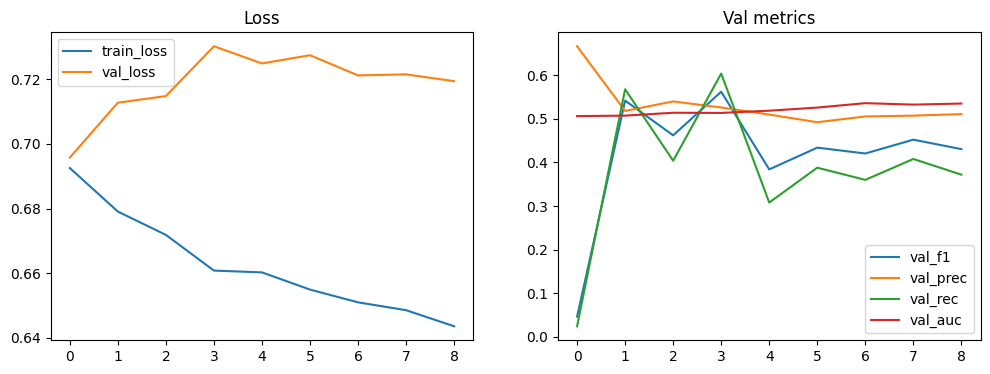

In [ ]:
model = HatefulMemesDetector()
model, history = train_model(model, train_loader, val_loader, epochs=10)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'],   label='val_loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history['val_f1'],   label='val_f1')
plt.plot(history['val_prec'], label='val_prec')
plt.plot(history['val_rec'],  label='val_rec')
plt.plot(history['val_auc'],  label='val_auc')
plt.legend(); plt.title("Val metrics")
plt.show()
